In [ ]:
import json
import pandas as pd
import numpy as np
import re

In [ ]:
file_dir = './data'
with open(f'{file_dir}/wikipedia-movies.json', mode='r') as file:
    wiki_movies_raw = json.load(file)

In [ ]:
len(wiki_movies_raw)

In [ ]:
# First 5 records
wiki_movies_raw[:5]

In [ ]:
# Now get the Kaggle data read in
kaggle_metadata = pd.read_csv(f'{file_dir}/movies_metadata.csv', low_memory=False)
ratings = pd.read_csv(f'{file_dir}/ratings.csv')

In [ ]:
kaggle_metadata.sample()

In [ ]:
wiki_movies_df = pd.DataFrame(wiki_movies_raw)
wiki_movies_df.columns.tolist()

In [ ]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie]
len(wiki_movies)

In [ ]:
wiki_movies = [movie for movie in wiki_movies_raw
               if ('Director' in movie or 'Directed by' in movie)
                   and 'imdb_link' in movie
                   and 'No. of episodes' not in movie]
len(wiki_movies)

In [ ]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune–Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    return movie

In [ ]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]

In [ ]:
wiki_movies_df = pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

In [ ]:
def clean_movie(movie):
    movie = dict(movie) #create a non-destructive copy
    alt_titles = {}
    # combine alternate titles into one list
    for key in ['Also known as','Arabic','Cantonese','Chinese','French',
                'Hangul','Hebrew','Hepburn','Japanese','Literally',
                'Mandarin','McCune-Reischauer','Original title','Polish',
                'Revised Romanization','Romanized','Russian',
                'Simplified','Traditional','Yiddish']:
        if key in movie:
            alt_titles[key] = movie[key]
            movie.pop(key)
    if len(alt_titles) > 0:
        movie['alt_titles'] = alt_titles

    # merge column names
    def change_column_name(old_name, new_name):
        if old_name in movie:
            movie[new_name] = movie.pop(old_name)
    change_column_name('Adaptation by', 'Writer(s)')
    change_column_name('Country of origin', 'Country')
    change_column_name('Directed by', 'Director')
    change_column_name('Distributed by', 'Distributor')
    change_column_name('Edited by', 'Editor(s)')
    change_column_name('Length', 'Running time')
    change_column_name('Original release', 'Release date')
    change_column_name('Music by', 'Composer(s)')
    change_column_name('Produced by', 'Producer(s)')
    change_column_name('Producer', 'Producer(s)')
    change_column_name('Productioncompanies ', 'Production company(s)')
    change_column_name('Productioncompany ', 'Production company(s)')
    change_column_name('Released', 'Release Date')
    change_column_name('Release Date', 'Release date')
    change_column_name('Screen story by', 'Writer(s)')
    change_column_name('Screenplay by', 'Writer(s)')
    change_column_name('Story by', 'Writer(s)')
    change_column_name('Theme music composer', 'Composer(s)')
    change_column_name('Written by', 'Writer(s)')

    return movie

In [ ]:
clean_movies = [clean_movie(movie) for movie in wiki_movies]
wiki_movies_df = pd.DataFrame(clean_movies)
sorted(wiki_movies_df.columns.tolist())

In [ ]:
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')

In [ ]:
wiki_movies_df.head()

In [ ]:
# remove duplicates
wiki_movies_df['imdb_id'] = wiki_movies_df['imdb_link'].str.extract(r'(tt\d{7})')
print(len(wiki_movies_df))
wiki_movies_df.drop_duplicates(subset='imdb_id', inplace=True)
print(len(wiki_movies_df))
wiki_movies_df.head()

In [ ]:
#Weed out the columns that have mostly null
wiki_columns_to_keep = [column for column in wiki_movies_df.columns if wiki_movies_df[column].isnull().sum() < len(wiki_movies_df) * 0.9]
wiki_movies_df = wiki_movies_df[wiki_columns_to_keep]

In [ ]:
wiki_movies_df.count()

In [ ]:
len(wiki_movies_df.columns.tolist())

In [ ]:
wiki_movies_df.dtypes

In [ ]:
box_office = wiki_movies_df['Box office'].dropna()
box_office.count()

In [ ]:
box_office[box_office.map(lambda x: type(x) != str)]

In [ ]:
box_office = box_office.apply(lambda x: ' '.join(x) if type(x) == list else x)

In [ ]:
def parse_dollars(s):
    # if s is not a string, return NaN
    if type(s) != str:
        return np.nan

    # if input is of the form $###.# million
    if re.match(r'\$\s*\d+\.?\d*\s*milli?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " million"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a million
        value = float(s) * 10**6

        # return value
        return value

    # if input is of the form $###.# billion
    elif re.match(r'\$\s*\d+\.?\d*\s*billi?on', s, flags=re.IGNORECASE):

        # remove dollar sign and " billion"
        s = re.sub('\$|\s|[a-zA-Z]','', s)

        # convert to float and multiply by a billion
        value = float(s) * 10**9

        # return value
        return value

    # if input is of the form $###,###,###
    elif re.match(r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)', s, flags=re.IGNORECASE):

        # remove dollar sign and commas
        s = re.sub('\$|,','', s)

        # convert to float
        value = float(s)

        # return value
        return value

    # otherwise, return NaN
    else:
        return np.nan

In [ ]:
form_one = r'\$\s*\d+\.?\d*\s*[mb]illi?on'
form_two = r'\$\s*\d{1,3}(?:[,\.]\d{3})+(?!\s[mb]illion)'
wiki_movies_df['box_office'] = box_office.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [ ]:
wiki_movies_df['box_office']

In [ ]:
wiki_movies_df['box_office']

In [ ]:
budget = wiki_movies_df['Budget'].dropna()
budget

In [ ]:
budget = budget.map(lambda x: ' '.join(x) if type(x) == list else x)
budget = budget.str.replace(r'\$.*[-—–](?![a-z])', '$', regex=True)
for b in budget.to_list():
    print(b)

In [ ]:
matches_form_one = budget.str.contains(form_one, flags=re.IGNORECASE, na=False)
matches_form_two = budget.str.contains(form_two, flags=re.IGNORECASE, na=False)
budget[~matches_form_one & ~matches_form_two]

In [78]:
budget = budget.str.replace(r'\[\d+\]\s*', '')
budget[~matches_form_one & ~matches_form_two]

16                   $2,500,000 [ citation needed ]
100                         £960,000 ($1.5 million)
135                                  USD$ 9 million
136                                         Unknown
142     $23 million (estimated) [ citation needed ]
                           ...                     
6995                                  $22.8 million
7015                                   $36 million 
7018         $70 million (gross) $59 million (net) 
7048                                  $175 million 
7070                                   €4.3 million
Name: Budget, Length: 212, dtype: object

In [79]:
wiki_movies_df['budget'] = budget.str.extract(f'({form_one}|{form_two})', flags=re.IGNORECASE)[0].apply(parse_dollars)

In [80]:
wiki_movies_df.drop('Budget', axis=1, inplace=True)

In [81]:
release_date = wiki_movies_df['Release date'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [82]:
date_form_one = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s[123]?\d,\s\d{4}'
date_form_two = r'\d{4}.[01]\d.[0123]\d'
date_form_three = r'(?:January|February|March|April|May|June|July|August|September|October|November|December)\s\d{4}'
date_form_four = r'\d{4}'

In [83]:
release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})', flags=re.IGNORECASE)

,0
0,"July 11, 1990"
1,"May 17, 1990"
2,"August 10, 1990"
3,"December 25, 1990"
4,"December 19, 1990"
...,...
7071,"December 25, 2018"
7072,"December 11, 2018"
7073,"November 8, 2018"
7074,"August 31, 2018"


In [84]:
wiki_movies_df['release_date'] = pd.to_datetime(release_date.str.extract(f'({date_form_one}|{date_form_two}|{date_form_three}|{date_form_four})')[0], infer_datetime_format=True)

In [85]:
running_time = wiki_movies_df['Running time'].dropna().apply(lambda x: ' '.join(x) if type(x) == list else x)

In [86]:
running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False).sum()

6528

In [87]:
running_time[running_time.str.contains(r'^\d*\s*minutes$', flags=re.IGNORECASE, na=False) != True]

9                                                 102 min
26                                                 93 min
28                                                32 min.
34                                                101 min
35                                                 97 min
                              ...                        
6500       114 minutes [1] 120 minutes (extended edition)
6643                                             104 mins
6709    90 minutes (theatrical) [1] 91 minutes (unrate...
7057    108 minutes (Original cut) 98 minutes (UK cut)...
7075                Variable; 90 minutes for default path
Name: Running time, Length: 366, dtype: object

In [88]:
running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False).sum()

6877

In [89]:
running_time[running_time.str.contains(r'^\d*\s*m', flags=re.IGNORECASE, na=False) != True]

668                     UK:84 min (DVD version) US:86 min
727                         78-102 min (depending on cut)
840                       Varies (79 [3] –84 [1] minutes)
1347                                              25 : 03
1443    United States: 77 minutes Argentina: 94 minute...
1499                                            1hr 35min
1551                                               varies
1774                    Netherlands:96 min, Canada:95 min
1777                                       approx. 14 min
2273                                           1 h 43 min
2993                                               1h 48m
3925                                              4 hours
4425    US domestic version: 86 minutes Original versi...
4967    Theatrical cut: 97 minutes Unrated cut: 107 mi...
5424                    115 [1] /123 [2] /128 [3] minutes
5447                                    1 hour 32 minutes
7075                Variable; 90 minutes for default path
Name: Running 

In [90]:
running_time_extract = running_time.str.extract(r'(\d+)\s*ho?u?r?s?\s*(\d*)|(\d+)\s*m')

In [91]:
running_time_extract = running_time_extract.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

In [92]:
wiki_movies_df['running_time'] = running_time_extract.apply(lambda row: row[0]*60 + row[1] if row[2] == 0 else row[2], axis=1)

In [93]:
wiki_movies_df.drop('Running time', axis=1, inplace=True)

In [94]:
kaggle_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [95]:
kaggle_metadata['adult'].value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

In [96]:
kaggle_metadata[~kaggle_metadata['adult'].isin(['True','False'])]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
kaggle_metadata = kaggle_metadata[kaggle_metadata['adult'] == 'False'].drop('adult',axis='columns')

In [98]:
kaggle_metadata['video'].value_counts()

False    45358
True        93
Name: video, dtype: int64

In [99]:
kaggle_metadata['video'] == 'True'

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464    False
45465    False
Name: video, Length: 45454, dtype: bool

In [100]:
kaggle_metadata['video'] = kaggle_metadata['video'] == 'True'

In [101]:
kaggle_metadata['budget'] = kaggle_metadata['budget'].astype(int)
kaggle_metadata['id'] = pd.to_numeric(kaggle_metadata['id'], errors='raise')
kaggle_metadata['popularity'] = pd.to_numeric(kaggle_metadata['popularity'], errors='raise')

In [102]:
kaggle_metadata['release_date'] = pd.to_datetime(kaggle_metadata['release_date'])

In [103]:
ratings.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Non-Null Count     Dtype  
---  ------     --------------     -----  
 0   userId     26024289 non-null  int64  
 1   movieId    26024289 non-null  int64  
 2   rating     26024289 non-null  float64
 3   timestamp  26024289 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [104]:
pd.to_datetime(ratings['timestamp'], unit='s')

0          2015-03-09 22:52:09
1          2015-03-09 23:07:15
2          2015-03-09 22:52:03
3          2015-03-09 22:52:26
4          2015-03-09 22:52:36
                   ...        
26024284   2009-10-31 23:26:04
26024285   2009-10-31 23:33:52
26024286   2009-10-31 23:29:24
26024287   2009-11-01 00:06:30
26024288   2009-10-31 23:30:58
Name: timestamp, Length: 26024289, dtype: datetime64[ns]

In [105]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

count          26,024,289.00
mean                    3.53
std                     1.07
min                     0.50
25%                     3.00
50%                     3.50
75%                     4.00
max                     5.00
Name: rating, dtype: float64

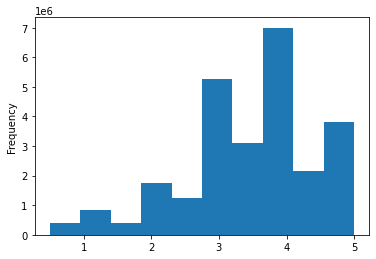

In [106]:
pd.options.display.float_format = '{:20,.2f}'.format
ratings['rating'].plot(kind='hist')
ratings['rating'].describe()

In [107]:
movies_df = pd.merge(wiki_movies_df, kaggle_metadata, on='imdb_id', suffixes=['_wiki','_kaggle'])

In [108]:
movies_df[['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
0,The Adventures of Ford Fairlane,The Adventures of Ford Fairlane
1,"After Dark, My Sweet","After Dark, My Sweet"
2,Air America,Air America
3,Alice,Alice
4,Almost an Angel,Almost an Angel
...,...,...
6047,A Fantastic Woman,A Fantastic Woman
6048,Permission,Permission
6049,Loveless,Loveless
6050,Gemini,Gemini


In [109]:
movies_df[movies_df['title_wiki'] != movies_df['title_kaggle']][['title_wiki','title_kaggle']]

,title_wiki,title_kaggle
27,China Cry,China Cry: A True Story
36,Daddy's Dyin' ...Who's Got the Will?,Daddy's Dyin'... Who's Got the Will?
38,The Dark Side of the Moon,The Dark Side of The Moon
42,Delta Force 2,Delta Force 2: The Colombian Connection
48,DuckTales the Movie:Treasure of the Lost Lamp,DuckTales: The Movie - Treasure of the Lost Lamp
...,...,...
5956,Chips,CHiPS
5971,Spark,Spark: A Space Tail
5994,Pirates of the Caribbean:Dead Men Tell No Tales,Pirates of the Caribbean: Dead Men Tell No Tales
6023,Valerian and the Cityof a Thousand Planets,Valerian and the City of a Thousand Planets


In [112]:
# Show any rows where title_kaggle is empty
movies_df[(movies_df['title_kaggle'] == '') | (movies_df['title_kaggle'].isnull())]

,url,year,imdb_link,title_wiki,Based on,Starring,Cinematography,Release date,Country,Language,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count


In [ ]:
# Drop the title_wiki column

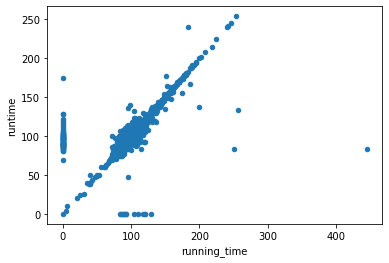

In [111]:
movies_df.fillna(0).plot(x='running_time', y='runtime', kind='scatter')

In [113]:
movies_df.drop(columns=['title_wiki','release_date_wiki','Language','Production company(s)'], inplace=True)

In [114]:
def fill_missing_kaggle_data(df, kaggle_column, wiki_column):
    df[kaggle_column] = df.apply(
        lambda row: row[wiki_column] if row[kaggle_column] == 0 else row[kaggle_column]
        , axis=1)
    df.drop(columns=wiki_column, inplace=True)

In [115]:
fill_missing_kaggle_data(movies_df, 'runtime', 'running_time')
fill_missing_kaggle_data(movies_df, 'budget_kaggle', 'budget_wiki')
fill_missing_kaggle_data(movies_df, 'revenue', 'box_office')
movies_df

,url,year,imdb_link,Based on,Starring,Cinematography,Release date,Country,Director,Distributor,...,release_date_kaggle,revenue,runtime,spoken_languages,status,tagline,title_kaggle,video,vote_average,vote_count
0,https://en.wikipedia.org/wiki/The_Adventures_o...,1990,https://www.imdb.com/title/tt0098987/,"[Characters, by Rex Weiner]","[Andrew Dice Clay, Wayne Newton, Priscilla Pre...",Oliver Wood,"[July 11, 1990, (, 1990-07-11, )]",United States,Renny Harlin,20th Century Fox,...,1990-07-11,"20,423,389.00",104.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Kojak. Columbo. Dirty Harry. Wimps.,The Adventures of Ford Fairlane,False,6.20,72.00
1,"https://en.wikipedia.org/wiki/After_Dark,_My_S...",1990,https://www.imdb.com/title/tt0098994/,"[the novel, After Dark, My Sweet, by, Jim Thom...","[Jason Patric, Rachel Ward, Bruce Dern, George...",Mark Plummer,"[May 17, 1990, (, 1990-05-17, ), (Cannes Film ...",United States,James Foley,Avenue Pictures,...,1990-08-24,"2,700,000.00",114.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,All they risked was everything.,"After Dark, My Sweet",False,6.50,17.00
2,https://en.wikipedia.org/wiki/Air_America_(film),1990,https://www.imdb.com/title/tt0099005/,"[Air America, by, Christopher Robbins]","[Mel Gibson, Robert Downey Jr., Nancy Travis, ...",Roger Deakins,"[August 10, 1990, (, 1990-08-10, )]",United States,Roger Spottiswoode,TriStar Pictures,...,1990-08-10,"33,461,269.00",112.00,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The few. The proud. The totally insane.,Air America,False,5.30,146.00
3,https://en.wikipedia.org/wiki/Alice_(1990_film),1990,https://www.imdb.com/title/tt0099012/,NaN,"[Alec Baldwin, Blythe Danner, Judy Davis, Mia ...",Carlo Di Palma,"[December 25, 1990, (, 1990-12-25, )]",United States,Woody Allen,Orion Pictures,...,1990-12-25,"7,331,647.00",102.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Alice,False,6.30,57.00
4,https://en.wikipedia.org/wiki/Almost_an_Angel,1990,https://www.imdb.com/title/tt0099018/,NaN,"[Paul Hogan, Elias Koteas, Linda Kozlowski]",Russell Boyd,"December 19, 1990",US,John Cornell,Paramount Pictures,...,1990-12-21,"6,939,946.00",95.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Who does he think he is?,Almost an Angel,False,5.60,23.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6047,https://en.wikipedia.org/wiki/A_Fantastic_Woman,2018,https://www.imdb.com/title/tt5639354/,NaN,"[Daniela Vega, Francisco Reyes]",Benjamín Echazarreta,"[12 February 2017, (, 2017-02-12, ), (, Berlin...","[Chile, Germany, Spain, United States, [2]]",Sebastián Lelio,"[Participant Media (Chile), Piffl Medien (Germ...",...,2017-04-06,"3,700,000.00",104.00,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,A Fantastic Woman,False,7.20,13.00
6048,https://en.wikipedia.org/wiki/Permission_(film),2018,https://www.imdb.com/title/tt5390066/,NaN,"[Rebecca Hall, Dan Stevens, Morgan Spector, Fr...",Adam Bricker,"[April 22, 2017, (, 2017-04-22, ), (, Tribeca ...",United States,Brian Crano,Good Deed Entertainment,...,2017-04-22,nan,96.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Permission,False,0.00,1.00
6049,https://en.wikipedia.org/wiki/Loveless_(film),2018,https://www.imdb.com/title/tt6304162/,NaN,"[Maryana Spivak, Aleksey Rozin, Matvey Novikov...",Mikhail Krichman,"[18 May 2017, (, 2017-05-18, ), (, Cannes, ), ...","[Russia, France, Belgium, Germany, [3]]",Andrey Zvyagintsev,"[Sony Pictures Releasing, (Russia), [1]]",...,2017-06-01,"4,800,000.00",128.00,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Loveless,False,7.80,26.00
6050,https://en.wikipedia.org/wiki/Gemini_(2017_film),2018,https://www.imdb.com/title/tt5795086/,NaN,"[Lola Kirke, Zoë Kravitz, Greta Lee, Michelle ...",Andrew Reed,"[March 12, 2017, (, 2017-03-12, ), (, SXSW, ),...",United States,Aaron Katz,Neon,...,2017-03-12,"200,340.00",92.00,"[{'iso_639_1': 'en', 'name': 'English'}]",Post Production,NaN,Gemin

In [116]:
for col in movies_df.columns:
    lists_to_tuples = lambda x: tuple(x) if type(x) == list else x
    value_counts = movies_df[col].apply(lists_to_tuples).value_counts(dropna=False)
    num_values = len(value_counts)
    if num_values == 1:
        print(col)

video


In [117]:
movies_df['video'].value_counts(dropna=False)

False    6052
Name: video, dtype: int64

In [118]:
movies_df = movies_df.loc[:, ['imdb_id','id','title_kaggle','original_title','tagline','belongs_to_collection','url','imdb_link',
                       'runtime','budget_kaggle','revenue','release_date_kaggle','popularity','vote_average','vote_count',
                       'genres','original_language','overview','spoken_languages','Country',
                       'production_companies','production_countries','Distributor',
                       'Producer(s)','Director','Starring','Cinematography','Editor(s)','Writer(s)','Composer(s)','Based on'
                      ]]

In [119]:
movies_df.rename({'id':'kaggle_id',
                  'title_kaggle':'title',
                  'url':'wikipedia_url',
                  'budget_kaggle':'budget',
                  'release_date_kaggle':'release_date',
                  'Country':'country',
                  'Distributor':'distributor',
                  'Producer(s)':'producers',
                  'Director':'director',
                  'Starring':'starring',
                  'Cinematography':'cinematography',
                  'Editor(s)':'editors',
                  'Writer(s)':'writers',
                  'Composer(s)':'composers',
                  'Based on':'based_on'
                 }, axis='columns', inplace=True)